In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading keras and FBD experiment...
from keras import backend as K
from helpers import *
from experiment import *
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import sys
import numpy as np

# to show the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import Model, Input

# loading resnet
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


Initialized TensorFlow


In [2]:
# see https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 5s 87us/step - loss: 0.2710 - acc: 0.9161 - val_loss: 0.0598 - val_acc: 0.9808
Epoch 2/12
60000/60000 [==============================] - 4s 72us/step - loss: 0.0926 - acc: 0.9722 - val_loss: 0.0417 - val_acc: 0.9861
Epoch 3/12
60000/60000 [==============================] - 5s 91us/step - loss: 0.0691 - acc: 0.9794 - val_loss: 0.0357 - val_acc: 0.9873
Epoch 4/12
60000/60000 [==============================] - 5s 85us/step - loss: 0.0578 - acc: 0.9824 - val_loss: 0.0325 - val_acc: 0.9886
Epoch 5/12
60000/60000 [==============================] - 5s 79us/step - loss: 0.0474 - acc: 0.9861 - val_loss: 0.0276 - val_acc: 0.9903
Epoch 6/12
60000/60000 [==============================] - 5s 75us/step - loss: 0.0424 - acc: 0.9869 - val_loss: 0.0272 - val_acc: 0.9908
Epoch 7/12
60000/60000 [==============================]

In [81]:
# probability of input failure
p = 0.0005

In [82]:
# calculating np
np.prod(list(map(int, model.inputs[0].shape[1:]))) * p

0.392

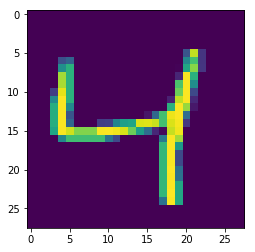

In [83]:
x = np.array([x_train[2]])
plt.imshow(x.reshape(28, 28))

In [84]:
class ModelInputCrashExperiment(Experiment):
    def __init__(self, model, p=0.01, name='exp'):
        """ Get an experiment based on a model, assuming input failures
            p failures at input
        """

        # saving p_inference
        self.p_inference = [0, p]
        
        in_shape = model.layers[0].input.shape[1:]
        out_shape = model.layers[-1].output.shape[1:]
        assert len(out_shape) == 1, "Only support 1D output"
        out_N = int(out_shape[0])

        # rewrite using https://github.com/raghakot/keras-vis/issues/37
        self.N = [0, 0, out_N]

        def IdentityLayer(input_shape=None):
            """ A layer which does nothing """
            return Lambda(
                lambda x: x + 0, input_shape=input_shape, name='Identity')

        # creating correct and crashing models
        inp = Input(shape = in_shape)
        self.model_correct  = Model(inputs = inp, outputs = model(IdentityLayer     (   input_shape = in_shape)(inp)))
        self.model_crashing = Model(inputs = inp, outputs = model(IndependentCrashes(p, input_shape = in_shape)(inp)))

In [85]:
# obtaining experiment from a model
exp = ModelInputCrashExperiment(model, p = p)

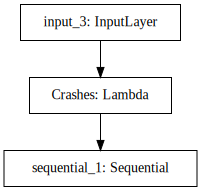

In [86]:
# plotting crashing architecture
SVG(model_to_dot(exp.model_crashing).create(prog='dot', format='svg'))

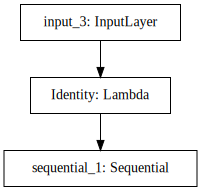

In [87]:
# plotting correct architecture
SVG(model_to_dot(exp.model_correct).create(prog='dot', format='svg'))

In [108]:
def predict(model, x):
    preds = model.predict(x)[0]
    sort = np.argsort(-preds)[:3]
    print(' '.join(['%d: %.5f%%' % (i, 100 * preds[i]) for i in sort]))

In [115]:
predict(exp.model_crashing, x)

4: 99.99986% 1: 0.00009% 7: 0.00002%


In [116]:
predict(exp.model_correct, x)

4: 99.99986% 1: 0.00009% 7: 0.00002%


In [117]:
exp.get_bound_b3(x)['mean']

array([ 8.88665769e-14,  1.02800852e-08,  1.76279114e-09,  1.06669366e-13,
       -1.64115619e-08,  2.72106122e-13,  9.76671001e-13,  2.70655165e-09,
        1.74819863e-11,  1.23302091e-09], dtype=float32)

In [118]:
np.mean(exp.compute_error(np.array(x), repetitions = 100000), axis = 1)

array([[ 1.7349812e-13,  2.1797582e-08,  3.3550982e-09,  2.6190514e-13,
        -3.1456949e-08,  8.5594520e-13,  2.7468715e-12,  6.5210477e-09,
         3.5221995e-11,  1.8008336e-09]], dtype=float32)

(array([669.,  10.,   7.,   9.,   8.,   5.,  27.,   5.,   8.,  36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

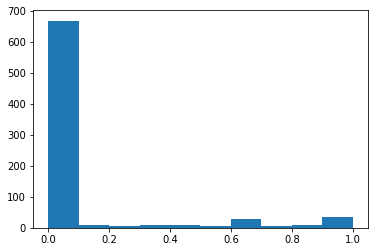

In [107]:
plt.hist(x.flatten())